### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import *

#from utilities import cal_score, convert_types, create_dt_feats

### Params

In [2]:
is_log_target = True
is_per_area_target = True

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]

#cols_feats_add = ['encoded_latlon', 'building_per_land_area'] # add feats into model
cols_num_add = ['building_per_land_area', 'N_txn_per_town']
cols_cat_add = ['encoded_latlon']

#cols_feats_rm = [] # TODO: implement before using it
#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

### Processing

In [3]:
def pre_processing(df, cols_num, cols_cat): #, cols_feats
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('../object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['building_per_land_area'] = df['building_area'] / df['land_area']
 
    #cols_feats = cols_num + cols_cat + cols_feats_add
    
    return df  #, cols_feats

In [4]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding

class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_feats, col_target, n_ran_encode=4):
        # cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_feats = cols_feats
        self.col_target = col_target
        
        # Numbers
        self.n_ran_encode = n_ran_encode
        
        # encoders
        #self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.cat_astyper = CategoricalColumnsEncoder(mode='pandas')
        
    def fit_transform(self, df):
        df = df.copy()
    
#        encoded1 = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
#        encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        self.cat_astyper.fit_transform(df, self.cols_cat)
        df_town = (
            pd.DataFrame(df['town'].value_counts()).reset_index()
            .rename({'town': 'N_txn_per_town', 'index':'town'}, axis=1)
        )
        self.df_town = df_town
        df = df.merge(self.df_town, on='town', how='left')
    
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
#        encoded1 = self.tar_encoder.transform(df[self.cols_cat])
#        encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        self.cat_astyper.transform(df)
        df = df.merge(self.df_town, on='town', how='left')

        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)


In [5]:
def post_processing(y_pred, df):
    """Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area'].values
        
    return y_pred_final

### Columns

In [6]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor',
            'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area',
            'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate',
            'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate',
            'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250',
            'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500',
            'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500',
            'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500',
            'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000',
            'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000',
            'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000',
            'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000',
            'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000',
            'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN',
            'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10',
            'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10',
            'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN',
            'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village',
            'I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']
cols_feats = cols_num + cols_cat

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']

### Read data

In [7]:
df = pd.read_csv('../dataset/train.csv', dtype=object)
df.head(5)

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469802848528126,647603.7704719775
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.07357348973039,3321452.0
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.46208108983661,9570885.316206373
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.62896580763416,14215011.127100045
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.1312362968124,762711.9757135696


### Preprocessing

In [8]:
df = pre_processing(df, cols_num, cols_cat)

c:\python36\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [9]:
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_feats = cols_num + cols_cat

In [10]:
df.check()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,month_txn_dt,quarter_txn_dt,year_txn_dt,dow_building_complete_dt,day_in_year_building_complete_dt,month_building_complete_dt,quarter_building_complete_dt,year_building_complete_dt,dt_diff_building_complete_dt_txn_dt,building_per_land_area
0,e3mMIMR3JJqCaXz1,8,21,18674.0,4.0,3,2,6271.0,2,NaN,...,1,0,51,6,66,2,0,17,12403.0,0.188387
1,LgwzgklNvy4QCtq5,8,7,18800.0,5.0,1,2,7885.0,2,NaN,...,6,2,51,3,220,7,2,21,10915.0,0.354898
2,ucIR2NLLsC3T650L,8,7,19289.0,4.0,1,2,6028.0,2,NaN,...,10,3,52,1,188,6,2,16,13261.0,0.260621
3,jre1pJhcQj91Kdky,8,21,20385.0,24.0,0,2,18325.0,0,NaN,...,10,3,55,6,75,2,0,50,2060.0,1.191074
4,rQpYpY9nRG7X5mmr,1,21,20657.0,2.0,4,2,6880.0,2,NaN,...,7,2,56,6,310,10,3,18,13777.0,0.076470
59995,Oh5Hwr9LrWApC2mr,1,5,19040.0,2.0,4,2,9193.0,2,NaN,...,1,0,52,2,68,2,0,25,9847.0,0.132647
59996,PiOgZqfsDVlTq1zs,8,13,19706.0,14.0,2,5,17168.0,0,3.738412,...,11,3,53,4,13,0,0,47,2538.0,1.281212
59997,FQmlgGohzzWuKUzu,8,7,19901.0,11.0,0,2,13729.0,0,NaN,...,6,2,54,2,224,7,2,37,6172.0,0.722181
59998,zjzfMwXhDswdEaI2,8,13,19975.0,5.0,1,2,7063.0,2,NaN,...,8,2,54,0,128,4,1,19,12912.0,0.378677
59999,iN4H6wBMtvJpF0SN,8,7,20385.0,5.0,1,2,8310.0,2,NaN,...,10,3,55,1,280,9,3,22,12075.0,0.325006


shape = (60000, 252)


#### Analysis on town txn (no need to rerun)

In [11]:
town_area = df[['town', 'town_area']].drop_duplicates().set_index('town')

In [12]:
df[['town', 'town_area']].drop_duplicates().sort_values('town').check()

,town,town_area
284,0,56.265900
15066,10,34.863201
12,10,16.316999
129,101,11.361400
46386,101,27.404499
68,91,62.368198
45566,91,13.682100
2245,94,42.409901
352,96,5.681500
1961,97,87.392502


shape = (258, 2)


In [13]:
town_min_area = df.groupby('town')['town_area'].min()
town_max_area = df.groupby('town')['town_area'].max()
town_mean_area = df.groupby('town')['town_area'].mean()

In [14]:
df2 = df[['txn_dt', 'town', 'town_area']].sort_values('txn_dt')[['town', 'town_area']]

In [15]:
town_last_area = df2.drop_duplicates('town', keep='last').sort_values('town').set_index('town')

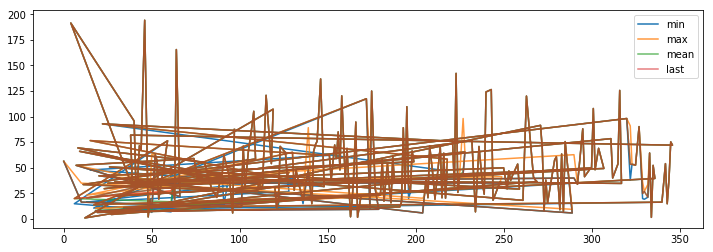

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(town_min_area, label='min')
plt.plot(town_max_area, label='max', alpha=0.8)
plt.plot(town_mean_area, label='mean', alpha=0.7)
plt.plot(town_last_area, label='last', alpha=0.6)
plt.legend(); plt.show()

In [17]:
town_mean_area.check()

town
0      56.265900
10     16.353029
101    11.373684
102    71.040001
103    30.783701
90     42.750801
91     62.314697
94     42.409901
96      5.681500
97     87.392502
Name: town_area, dtype: float32

shape = (213,)


In [18]:
town_txn = df['town'].value_counts()

In [19]:
df_town = pd.DataFrame(town_txn).reset_index().rename({'town': 'N_txn', 'index':'town'}, axis=1)

In [20]:
df_town.check()

,town,N_txn
0,180,2604
1,13,2274
2,10,2059
3,158,1797
4,164,1630
208,59,1
209,232,1
210,255,1
211,300,1
212,223,1


shape = (213, 2)


In [21]:
town_log_per_area_total_price = df.groupby('town')['log_per_area_total_price'].mean()

In [22]:
town_log_per_area_total_price.check()

town
0      12.818285
10     14.028280
101    15.393057
102    12.150455
103    12.537035
90     12.341266
91     14.746328
94     12.654356
96     14.499106
97     12.645203
Name: log_per_area_total_price, dtype: float32

shape = (213,)


In [23]:
df_town = pd.DataFrame(town_txn).rename({'town': 'N_txn'}, axis=1)

In [24]:
df_town['log_per_area_total_price'] = town_log_per_area_total_price

In [25]:
df_town['mean_area'] = town_mean_area

In [26]:
town_mean_area.check()

town
0      56.265900
10     16.353029
101    11.373684
102    71.040001
103    30.783701
90     42.750801
91     62.314697
94     42.409901
96      5.681500
97     87.392502
Name: town_area, dtype: float32

shape = (213,)


In [27]:
df_town['mean_area']

180     23.137300
13      20.155113
10      16.353029
158    120.225502
164     19.738300
17      13.602006
208     71.235397
39      31.578699
188     34.804600
101     11.373684
204      5.747100
6       19.782639
330     26.733501
284      7.435100
34      11.144067
84      29.557800
196     33.115543
290     39.892139
174     12.723260
148     31.509001
50       8.735387
91      62.314697
61      16.718010
53      56.821602
179      9.305114
62      31.257799
206     40.275299
52      62.703400
214     70.656502
15      76.480751
          ...    
23      29.444901
43      71.452301
268     38.020401
240    124.033997
239     24.037500
307     49.213200
89      38.608101
182     17.269699
195    109.631599
271     91.382698
198     66.350197
248     36.144901
31      30.984200
141     14.777200
107     90.839600
263    120.031601
131     27.878000
175    124.917801
143     72.218903
261     18.085600
234      6.801800
40      95.622398
64     165.493805
46     194.158401
127     41

In [28]:
df_town['txn_per_mean_area'] = df_town['N_txn'] / df_town['mean_area']

In [29]:
df_town.check()

,N_txn,log_per_area_total_price,mean_area,txn_per_mean_area
180,2604,14.184411,23.137300,112.545541
13,2274,14.119159,20.155113,112.824968
10,2059,14.028280,16.353029,125.909394
158,1797,13.906591,120.225502,14.946912
164,1630,13.850145,19.738300,82.580565
59,1,12.098044,76.315300,0.013104
232,1,11.984272,76.366203,0.013095
255,1,12.564144,42.166199,0.023716
300,1,11.722550,49.851700,0.020059
223,1,11.774219,142.201294,0.007032


shape = (213, 4)


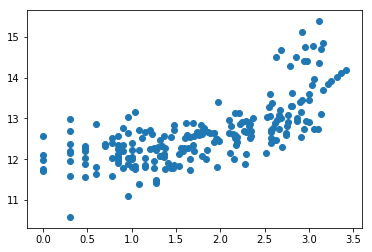

In [30]:
plt.scatter(np.log10(df_town['N_txn'].values), df_town['log_per_area_total_price'].values)
plt.show()

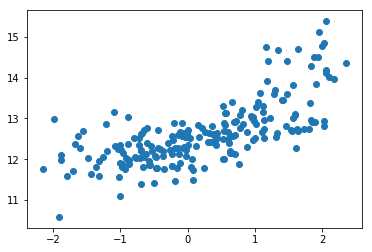

In [31]:
plt.scatter(np.log10(df_town['txn_per_mean_area'].values), df_town['log_per_area_total_price'].values)
plt.show()

In [32]:
df_town['log_txn_per_mean_area'] = np.log10(df_town['txn_per_mean_area'])

In [33]:
df_town['log_N_txn'] = np.log10(df_town['N_txn'])

In [34]:
df_town.corr()

,N_txn,log_per_area_total_price,mean_area,txn_per_mean_area,log_txn_per_mean_area,log_N_txn
N_txn,1.000000,0.723317,-0.214324,0.733003,0.718091,0.766373
log_per_area_total_price,0.723317,1.000000,-0.304157,0.646151,0.708093,0.703037
mean_area,-0.214324,-0.304157,1.000000,-0.417661,-0.572949,-0.315617
txn_per_mean_area,0.733003,0.646151,-0.417661,1.000000,0.683928,0.570954
log_txn_per_mean_area,0.718091,0.708093,-0.572949,0.683928,1.000000,0.935865
log_N_txn,0.766373,0.703037,-0.315617,0.570954,0.935865,1.000000


In [35]:
df_town[['txn_per_mean_area', 'log_per_area_total_price']].corr()

,txn_per_mean_area,log_per_area_total_price
txn_per_mean_area,1.000000,0.646151
log_per_area_total_price,0.646151,1.000000


### Grid search

In [36]:
# grid search
params_fix = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.01 }

lgb_other_params = {'num_boost_round': 20000,
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000 }

# prvs baseline best estimator
# ('objective', 'mse'), ('metric', 'mape'),
# ('learning_rate', 0.015), ('num_leaves', 255),
# ('feature_fraction', 0.5), ('min_data_in_leaf', 5),
# ('lambda_l1', 0.1), ('lambda_l2', 0.1)),
# 5524.863045737181,
# [5528.862755759428, 5530.862894274216, 5514.863487177898]]

#params_gsearch = {'max_depth':[-1, 8],
#                  'num_leaves': [200, 255]}

#params_gsearch = {'max_depth': [-1, 8, 16, 24],
#                  'num_leaves': [200, 255, 300],           # may reduce in dim-reduction exp
#                  'feature_fraction': [0.5, 0.75, 1.0],
#                  'min_data_in_leaf': [5, 10, 20],
#                  'lambda_l1': [0, 0.01, 0.1],
#                  'lambda_l2': [0, 0.01, 0.1],
#                 }
params_gsearch = {'max_depth': list(range(16, 25)),
                  'num_leaves': list(range(255, 351)),           # may reduce in dim-reduction exp
                  'feature_fraction': [0.2, 0.3, 0.4, 0.5, 0.6],
                  'min_data_in_leaf': [5, 6, 7, 8, 9, 10],
                  'lambda_l1': [0, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.12],
                  'lambda_l2': [0, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.12],
                 }
N_fold = 3
N_iter = 50
score_low_bound = 5700 # if score smaller than this, skip the param set

In [37]:
prev_best_params = [
    (('max_depth', 16), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 10), ('lambda_l1', 0.01), ('lambda_l2', 0.1)),
    (('max_depth', 24), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 10), ('lambda_l1', 0.1), ('lambda_l2', 0.0)),
    (('max_depth', 16), ('num_leaves', 200), ('feature_fraction', 0.5), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.0)),
    (('max_depth', 24), ('num_leaves', 255), ('feature_fraction', 0.5), ('min_data_in_leaf', 5), ('lambda_l1', 0.01), ('lambda_l2', 0.01)),
    (('max_depth', 16), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.01)),
    (('max_depth', 16), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 10), ('lambda_l1', 0.1), ('lambda_l2', 0.0)),
    (('max_depth', 24), ('num_leaves', 255), ('feature_fraction', 0.5), ('min_data_in_leaf', 5), ('lambda_l1', 0.01), ('lambda_l2', 0.1)),
    (('max_depth', -1), ('num_leaves', 200), ('feature_fraction', 0.5), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.01)),
    (('max_depth', 16), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 20), ('lambda_l1', 0.1), ('lambda_l2', 0.0)),
    (('max_depth', -1), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 20), ('lambda_l1', 0.1), ('lambda_l2', 0.0)),
]

#### Round 1

In [38]:
# Round 1
rand_params_set = [dict(s) for s in prev_best_params]
for i in range(N_iter):
    params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    while params_rand in rand_params_set:
        params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    rand_params_set.append(params_rand)
gsearch = {}

In [39]:
rand_params_set[:20]

[{'feature_fraction': 0.5,
  'lambda_l1': 0.01,
  'lambda_l2': 0.1,
  'max_depth': 16,
  'min_data_in_leaf': 10,
  'num_leaves': 300},
 {'feature_fraction': 0.5,
  'lambda_l1': 0.1,
  'lambda_l2': 0.0,
  'max_depth': 24,
  'min_data_in_leaf': 10,
  'num_leaves': 300},
 {'feature_fraction': 0.5,
  'lambda_l1': 0.1,
  'lambda_l2': 0.0,
  'max_depth': 16,
  'min_data_in_leaf': 5,
  'num_leaves': 200},
 {'feature_fraction': 0.5,
  'lambda_l1': 0.01,
  'lambda_l2': 0.01,
  'max_depth': 24,
  'min_data_in_leaf': 5,
  'num_leaves': 255},
 {'feature_fraction': 0.5,
  'lambda_l1': 0.1,
  'lambda_l2': 0.01,
  'max_depth': 16,
  'min_data_in_leaf': 5,
  'num_leaves': 300},
 {'feature_fraction': 0.5,
  'lambda_l1': 0.1,
  'lambda_l2': 0.0,
  'max_depth': 16,
  'min_data_in_leaf': 10,
  'num_leaves': 300},
 {'feature_fraction': 0.5,
  'lambda_l1': 0.01,
  'lambda_l2': 0.1,
  'max_depth': 24,
  'min_data_in_leaf': 5,
  'num_leaves': 255},
 {'feature_fraction': 0.5,
  'lambda_l1': 0.1,
  'lambda_l2':

In [40]:
t0 = time.time()
gsearch = {}
folds = KFold(n_splits=N_fold, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_target]).construct()
    lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_target], reference=lgb_train).construct()
        
    # random sample - grid search
    rand_params_next = []
    for params_rand in rand_params_set:
        params = params_fix.copy()
        params.update( params_rand )

        model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)

        y_pred = model.predict(df_val[cols_feats])
        mse = mean_squared_error(df_val[col_target], y_pred)
        mae = mean_absolute_error(df_val[col_target], y_pred)
        mape = cal_mape(df_val[col_target], y_pred)
        
        y_pred_final = post_processing(y_pred, df_val)
        score = cal_score(df_val['total_price'], y_pred_final)

        print('params:', params)
        print('score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f.' % (score, mse, mae, mape))

        if i_fold==0 and score < score_low_bound:
            continue

        rand_params_next.append(params_rand)
        tuple_params = tuple(params.items())
        if tuple_params not in gsearch:
            gsearch[tuple_params] = [[], [], [], [], []]
        gsearch[tuple_params][0].append(model.best_iteration) # model
        gsearch[tuple_params][1].append(score)
        gsearch[tuple_params][2].append(mse)
        gsearch[tuple_params][3].append(mae)
        gsearch[tuple_params][4].append(mape)
        
    rand_params_set = rand_params_next
# aggregate, sort gsearch results
gsearch_results = [[key, *[np.mean(val_i) for val_i in val[1:]], *val] for key, val in gsearch.items()]
gsearch_results.sort(key= lambda x: x[1], reverse=True)
t1 = time.time()

==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00971127
[4000]	valid_0's mape: 0.00951804
[6000]	valid_0's mape: 0.00946807
[8000]	valid_0's mape: 0.00944898
[10000]	valid_0's mape: 0.00944065
[12000]	valid_0's mape: 0.0094359
[14000]	valid_0's mape: 0.0094339
[16000]	valid_0's mape: 0.00943238
[18000]	valid_0's mape: 0.00943122
[20000]	valid_0's mape: 0.00943052
Did not meet early stopping. Best iteration is:
[20000]	valid_0's mape: 0.00943052
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 16, 'num_leaves': 300, 'feature_fraction': 0.5, 'min_data_in_leaf': 10, 'lambda_l1': 0.01, 'lambda_l2': 0.1}
score, mse, mae, mape: 5757.86934, 0.03838, 0.12542, 0.00943.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00969185
[4000]	valid_0's mape: 0.00950987
[6000]	valid_0's mape: 0.00946418
[8000]	valid_0's mape: 0.00944

[6000]	valid_0's mape: 0.0094602
[8000]	valid_0's mape: 0.00943765
[10000]	valid_0's mape: 0.00942625
[12000]	valid_0's mape: 0.00942024
[14000]	valid_0's mape: 0.0094169
[16000]	valid_0's mape: 0.00941487
[18000]	valid_0's mape: 0.00941354
[20000]	valid_0's mape: 0.00941276
Did not meet early stopping. Best iteration is:
[19986]	valid_0's mape: 0.00941276
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 273, 'feature_fraction': 0.4, 'min_data_in_leaf': 5, 'lambda_l1': 0.04, 'lambda_l2': 0.04}
score, mse, mae, mape: 5758.86947, 0.03836, 0.12518, 0.00941.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.010043
[4000]	valid_0's mape: 0.00974155
[6000]	valid_0's mape: 0.0096632
[8000]	valid_0's mape: 0.00963285
[10000]	valid_0's mape: 0.00961747
[12000]	valid_0's mape: 0.0096093
[14000]	valid_0's mape: 0.00960444
[16000]	valid_0's mape: 0.00960091
[18000]	v

[2000]	valid_0's mape: 0.0100496
[4000]	valid_0's mape: 0.00975419
[6000]	valid_0's mape: 0.00967633
[8000]	valid_0's mape: 0.00964642
[10000]	valid_0's mape: 0.00963169
[12000]	valid_0's mape: 0.0096232
[14000]	valid_0's mape: 0.00961774
[16000]	valid_0's mape: 0.009614
[18000]	valid_0's mape: 0.00961165
[20000]	valid_0's mape: 0.00960973
Did not meet early stopping. Best iteration is:
[19997]	valid_0's mape: 0.00960973
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 19, 'num_leaves': 275, 'feature_fraction': 0.2, 'min_data_in_leaf': 5, 'lambda_l1': 0.05, 'lambda_l2': 0.12}
score, mse, mae, mape: 5692.86673, 0.04038, 0.12778, 0.00961.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00966684
[4000]	valid_0's mape: 0.00949222
[6000]	valid_0's mape: 0.00944815
[8000]	valid_0's mape: 0.00943267
[10000]	valid_0's mape: 0.00942556
[12000]	valid_0's mape: 0.00942169
[14000]	v

[2000]	valid_0's mape: 0.00967812
[4000]	valid_0's mape: 0.00952175
[6000]	valid_0's mape: 0.00948269
[8000]	valid_0's mape: 0.00946993
[10000]	valid_0's mape: 0.00946444
[12000]	valid_0's mape: 0.00946139
[14000]	valid_0's mape: 0.00945945
[16000]	valid_0's mape: 0.0094583
[18000]	valid_0's mape: 0.0094576
[20000]	valid_0's mape: 0.00945713
Did not meet early stopping. Best iteration is:
[20000]	valid_0's mape: 0.00945713
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 19, 'num_leaves': 337, 'feature_fraction': 0.6, 'min_data_in_leaf': 8, 'lambda_l1': 0.0, 'lambda_l2': 0.0}
score, mse, mae, mape: 5722.86905, 0.03859, 0.12575, 0.00945.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0100453
[4000]	valid_0's mape: 0.00979044
[6000]	valid_0's mape: 0.00972854
[8000]	valid_0's mape: 0.00970639
[10000]	valid_0's mape: 0.00969485
[12000]	valid_0's mape: 0.00968892
[14000]	va

[2000]	valid_0's mape: 0.00970368
[4000]	valid_0's mape: 0.00951524
[6000]	valid_0's mape: 0.00946618
[8000]	valid_0's mape: 0.00944955
[10000]	valid_0's mape: 0.00944169
[12000]	valid_0's mape: 0.00943785
[14000]	valid_0's mape: 0.00943533
[16000]	valid_0's mape: 0.00943394
[18000]	valid_0's mape: 0.00943308
[20000]	valid_0's mape: 0.00943239
Did not meet early stopping. Best iteration is:
[19999]	valid_0's mape: 0.00943239
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 302, 'feature_fraction': 0.5, 'min_data_in_leaf': 7, 'lambda_l1': 0.0, 'lambda_l2': 0.05}
score, mse, mae, mape: 5754.86931, 0.03853, 0.12543, 0.00943.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00981042
[4000]	valid_0's mape: 0.00956546
[6000]	valid_0's mape: 0.00949641
[8000]	valid_0's mape: 0.00946826
[10000]	valid_0's mape: 0.0094557
[12000]	valid_0's mape: 0.00944909
[14000]

[2000]	valid_0's mape: 0.0100396
[4000]	valid_0's mape: 0.00977964
[6000]	valid_0's mape: 0.00971406
[8000]	valid_0's mape: 0.00969007
[10000]	valid_0's mape: 0.0096788
[12000]	valid_0's mape: 0.00967198
[14000]	valid_0's mape: 0.00966827
[16000]	valid_0's mape: 0.0096663
[18000]	valid_0's mape: 0.0096652
[20000]	valid_0's mape: 0.00966473
Did not meet early stopping. Best iteration is:
[19927]	valid_0's mape: 0.00966473
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 22, 'num_leaves': 319, 'feature_fraction': 0.2, 'min_data_in_leaf': 7, 'lambda_l1': 0.12, 'lambda_l2': 0.01}
score, mse, mae, mape: 5674.86603, 0.04068, 0.12849, 0.00966.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00972262
[4000]	valid_0's mape: 0.00952482
[6000]	valid_0's mape: 0.009466
[8000]	valid_0's mape: 0.00944616
[10000]	valid_0's mape: 0.00943704
[12000]	valid_0's mape: 0.00943177
[14000]	val

[2000]	valid_0's mape: 0.00969975
[4000]	valid_0's mape: 0.00953029
[6000]	valid_0's mape: 0.00948979
[8000]	valid_0's mape: 0.00947322
[10000]	valid_0's mape: 0.00946456
[12000]	valid_0's mape: 0.00946036
[14000]	valid_0's mape: 0.00945798
[16000]	valid_0's mape: 0.00945637
Early stopping, best iteration is:
[16644]	valid_0's mape: 0.0094561
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 18, 'num_leaves': 325, 'feature_fraction': 0.4, 'min_data_in_leaf': 10, 'lambda_l1': 0.05, 'lambda_l2': 0.1}
score, mse, mae, mape: 5768.87064, 0.04015, 0.12593, 0.00945.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00968588
[4000]	valid_0's mape: 0.00954202
[6000]	valid_0's mape: 0.00950354
[8000]	valid_0's mape: 0.00948908
[10000]	valid_0's mape: 0.00948263
[12000]	valid_0's mape: 0.00947921
[14000]	valid_0's mape: 0.00947759
[16000]	valid_0's mape: 0.00947657
[18000]	valid_0's m

[2000]	valid_0's mape: 0.00969506
[4000]	valid_0's mape: 0.00953001
[6000]	valid_0's mape: 0.00948571
[8000]	valid_0's mape: 0.00947001
[10000]	valid_0's mape: 0.00946341
[12000]	valid_0's mape: 0.00945904
[14000]	valid_0's mape: 0.00945579
[16000]	valid_0's mape: 0.00945426
[18000]	valid_0's mape: 0.00945342
[20000]	valid_0's mape: 0.00945279
Did not meet early stopping. Best iteration is:
[19997]	valid_0's mape: 0.00945279
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 17, 'num_leaves': 325, 'feature_fraction': 0.4, 'min_data_in_leaf': 10, 'lambda_l1': 0.009, 'lambda_l2': 0.009}
score, mse, mae, mape: 5743.87073, 0.04012, 0.12589, 0.00944.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00974429
[4000]	valid_0's mape: 0.00956177
[6000]	valid_0's mape: 0.00950861
[8000]	valid_0's mape: 0.00948665
[10000]	valid_0's mape: 0.00947614
[12000]	valid_0's mape: 0.00947049
[1

[10000]	valid_0's mape: 0.00953536
[12000]	valid_0's mape: 0.00953125
Early stopping, best iteration is:
[12091]	valid_0's mape: 0.00953121
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 337, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.1, 'lambda_l2': 0.02}
score, mse, mae, mape: 5711.86731, 0.04014, 0.12671, 0.00953.


In [41]:
print('Total computing time:', t1-t0)

Total computing time: 67297.25318264961


In [42]:
for row in gsearch_results:
    print(*[x for i, x in enumerate(row) if i != 5])

(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 22), ('num_leaves', 303), ('feature_fraction', 0.4), ('min_data_in_leaf', 7), ('lambda_l1', 0.02), ('lambda_l2', 0.01)) 5777.8696262574085 0.03831723393899196 0.12511638775186285 0.009406627866557963 [5777.8696262574085] [0.03831723393899196] [0.12511638775186285] [0.009406627866557963]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 274), ('feature_fraction', 0.5), ('min_data_in_leaf', 7), ('lambda_l1', 0.02), ('lambda_l2', 0.12)) 5770.869441772318 0.03832971151732604 0.12531912484102112 0.009421080036285528 [5770.869441772318] [0.03832971151732604] [0.12531912484102112] [0.009421080036285528]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 17), ('num_leaves', 291), ('feature_fracti

In [49]:
good_params = [dict(row[0]) for row in gsearch_results]

In [51]:
print(good_params)

[{'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 22, 'num_leaves': 303, 'feature_fraction': 0.4, 'min_data_in_leaf': 7, 'lambda_l1': 0.02, 'lambda_l2': 0.01}, {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 274, 'feature_fraction': 0.5, 'min_data_in_leaf': 7, 'lambda_l1': 0.02, 'lambda_l2': 0.12}, {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 17, 'num_leaves': 291, 'feature_fraction': 0.4, 'min_data_in_leaf': 7, 'lambda_l1': 0.04, 'lambda_l2': 0.12}, {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 17, 'num_leaves': 325, 'feature_fraction': 0.4, 'min_data_in_leaf': 10, 'lambda_l1': 0.009, 'lambda_l2': 0.009}, {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learni

In [43]:
metrics = ['score', 'mse', 'mae', 'mape']

In [44]:
df_gsearch_results = []
for row in gsearch_results:
    result = dict(row[0])
    result['score'] = row[1]
    result['mse'] = row[2]
    result['mae'] = row[3]
    result['mape'] = row[4]
    result['best_iteration'] = np.mean(row[5]) #[m.best_iteration for m in row[5]]
    df_gsearch_results.append(result)
df_gsearch_results = pd.DataFrame(df_gsearch_results)
df_gsearch_results = df_gsearch_results[list(params_gsearch.keys())+metrics+['best_iteration']]
display(df_gsearch_results)

,max_depth,num_leaves,feature_fraction,min_data_in_leaf,lambda_l1,lambda_l2,score,mse,mae,mape,best_iteration
0,22,303,0.4,7,0.020,0.010,5777.869626,0.038317,0.125116,0.009407,19997.0
1,24,274,0.5,7,0.020,0.120,5770.869442,0.038330,0.125319,0.009421,19993.0
2,17,291,0.4,7,0.040,0.120,5769.870324,0.039144,0.125378,0.009415,19228.5
3,17,325,0.4,10,0.009,0.009,5768.869449,0.038514,0.125294,0.009419,20000.0
4,24,273,0.4,5,0.040,0.040,5767.870311,0.039219,0.125390,0.009415,19993.0
5,17,304,0.3,7,0.020,0.000,5766.369628,0.039722,0.126004,0.009463,19999.0
6,24,272,0.4,7,0.100,0.010,5763.870255,0.039044,0.125419,0.009417,16356.0
7,18,325,0.4,10,0.050,0.100,5762.869931,0.039336,0.125697,0.009439,17173.0
8,21,328,0.4,7,0.010,0.020,5762.370089,0.039350,0.125557,0.009428,19996.0
9,20,337,0.5,5,0.100,0.020,5761.369932,0.039442,0.125833,0.009448,12635.0


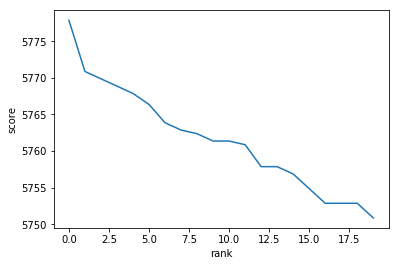

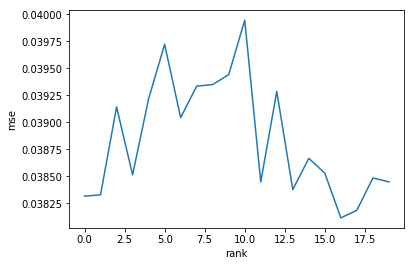

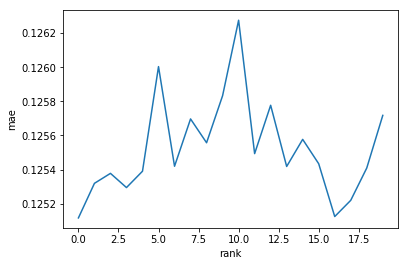

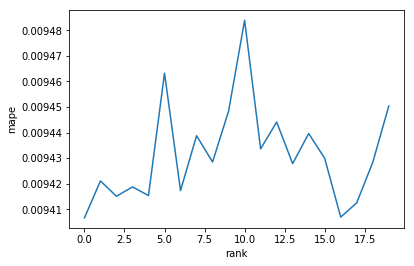

In [45]:
for name in metrics:
    plt.plot(df_gsearch_results[name])
    plt.xlabel('rank'); plt.ylabel(name); plt.show()

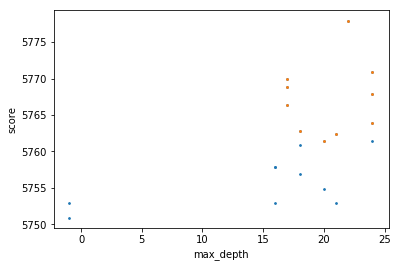

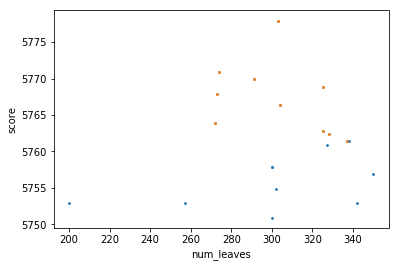

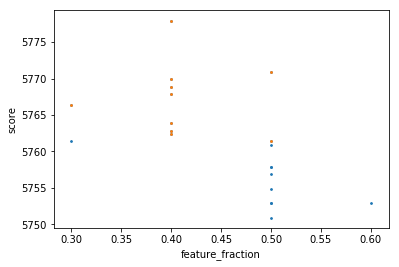

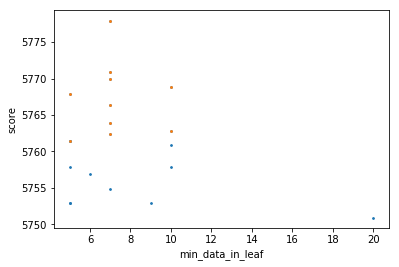

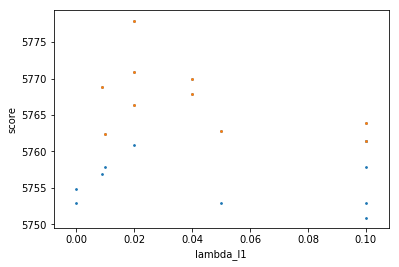

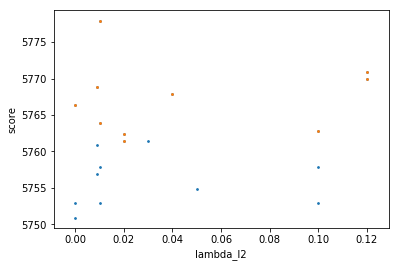

In [46]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['score'], s=3)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['score'][:10], s=3)
    plt.xlabel(p); plt.ylabel('score'); plt.show()

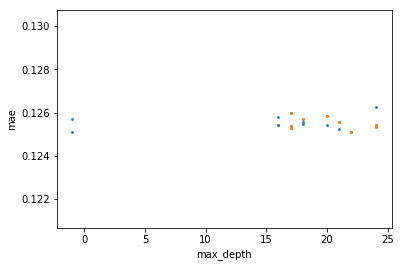

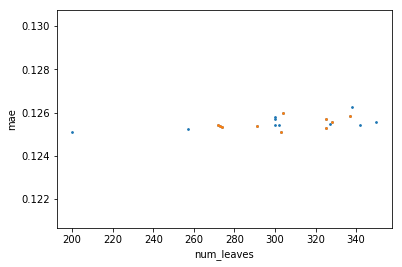

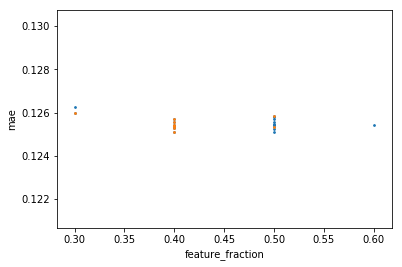

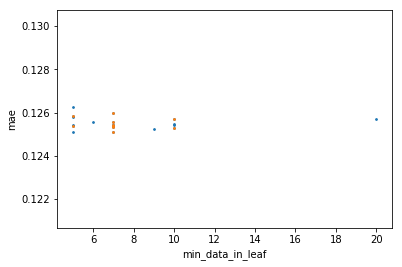

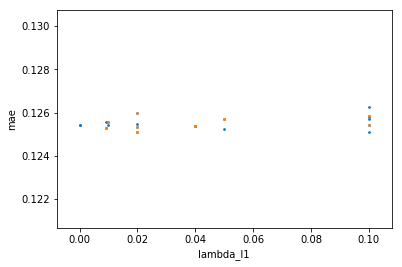

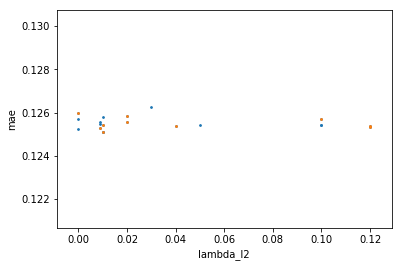

In [47]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['mae'], s=3)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['mae'][:10], s=3)
    plt.xlabel(p); plt.ylabel('mae'); plt.show()

In [46]:
df_gsearch_results.columns

Index(['max_depth', 'num_leaves', 'feature_fraction', 'min_data_in_leaf',
       'lambda_l1', 'lambda_l2', 'score', 'mse', 'mae', 'mape',
       'best_iteration'],
      dtype='object')

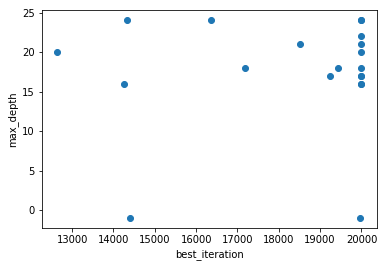

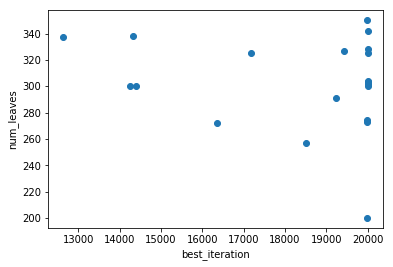

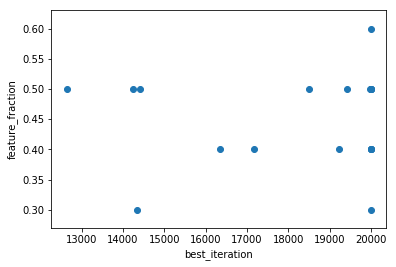

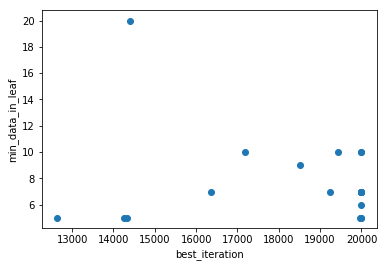

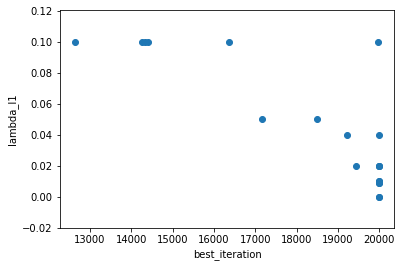

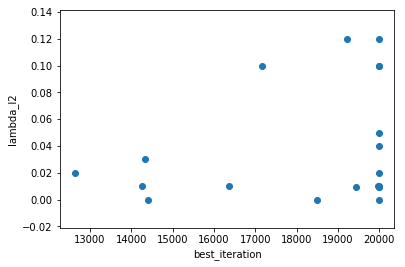

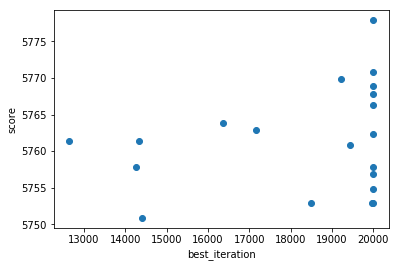

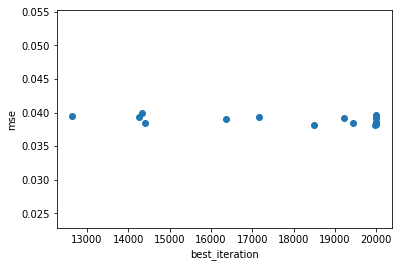

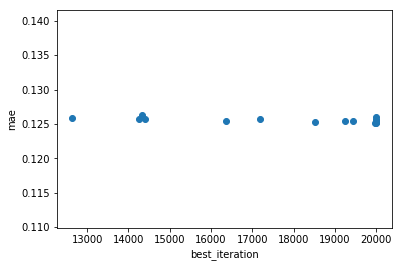

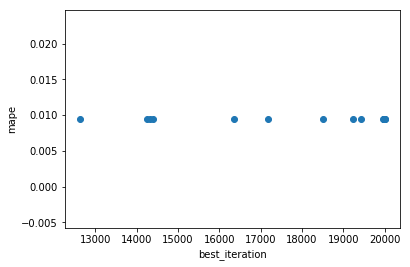

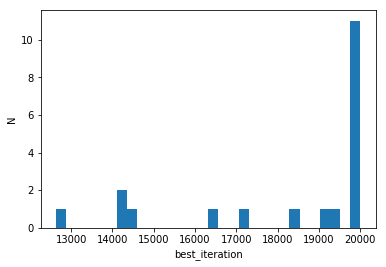

In [48]:
# best iteration
for c in df_gsearch_results.columns:
    if c != 'best_iteration':
        plt.scatter(df_gsearch_results['best_iteration'], df_gsearch_results[c])
        plt.ylabel(c)
    else:
        plt.hist(df_gsearch_results['best_iteration'], bins=30)
        plt.ylabel('N')        
    plt.xlabel('best_iteration')
    plt.show()

#### Round 1 rerun for other folds

In [53]:
good_params = [
    {'max_depth': 22, 'num_leaves': 303, 'feature_fraction': 0.4, 'min_data_in_leaf': 7, 'lambda_l1': 0.02, 'lambda_l2': 0.01}, 
    {'max_depth': 24, 'num_leaves': 274, 'feature_fraction': 0.5, 'min_data_in_leaf': 7, 'lambda_l1': 0.02, 'lambda_l2': 0.12},
    {'max_depth': 17, 'num_leaves': 291, 'feature_fraction': 0.4, 'min_data_in_leaf': 7, 'lambda_l1': 0.04, 'lambda_l2': 0.12}, 
    {'max_depth': 17, 'num_leaves': 325, 'feature_fraction': 0.4, 'min_data_in_leaf': 10, 'lambda_l1': 0.009, 'lambda_l2': 0.009}, 
    {'max_depth': 24, 'num_leaves': 273, 'feature_fraction': 0.4, 'min_data_in_leaf': 5, 'lambda_l1': 0.04, 'lambda_l2': 0.04}, 
    {'max_depth': 17, 'num_leaves': 304, 'feature_fraction': 0.3, 'min_data_in_leaf': 7, 'lambda_l1': 0.02, 'lambda_l2': 0.0}, 
    {'max_depth': 24, 'num_leaves': 272, 'feature_fraction': 0.4, 'min_data_in_leaf': 7, 'lambda_l1': 0.1, 'lambda_l2': 0.01}, 
    {'max_depth': 18, 'num_leaves': 325, 'feature_fraction': 0.4, 'min_data_in_leaf': 10, 'lambda_l1': 0.05, 'lambda_l2': 0.1}, 
    {'max_depth': 21, 'num_leaves': 328, 'feature_fraction': 0.4, 'min_data_in_leaf': 7, 'lambda_l1': 0.01, 'lambda_l2': 0.02}, 
    {'max_depth': 20, 'num_leaves': 337, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.1, 'lambda_l2': 0.02}, 
    {'max_depth': 24, 'num_leaves': 338, 'feature_fraction': 0.3, 'min_data_in_leaf': 5, 'lambda_l1': 0.1, 'lambda_l2': 0.03}, 
    {'max_depth': 18, 'num_leaves': 327, 'feature_fraction': 0.5, 'min_data_in_leaf': 10, 'lambda_l1': 0.02, 'lambda_l2': 0.009}, 
    {'max_depth': 16, 'num_leaves': 300, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.1, 'lambda_l2': 0.01}, 
    {'max_depth': 16, 'num_leaves': 300, 'feature_fraction': 0.5, 'min_data_in_leaf': 10, 'lambda_l1': 0.01, 'lambda_l2': 0.1}, 
    {'max_depth': 18, 'num_leaves': 350, 'feature_fraction': 0.5, 'min_data_in_leaf': 6, 'lambda_l1': 0.009, 'lambda_l2': 0.009}, 
    {'max_depth': 20, 'num_leaves': 302, 'feature_fraction': 0.5, 'min_data_in_leaf': 7, 'lambda_l1': 0.0, 'lambda_l2': 0.05}, 
    {'max_depth': -1, 'num_leaves': 200, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.1, 'lambda_l2': 0.01}, 
    {'max_depth': 21, 'num_leaves': 257, 'feature_fraction': 0.5, 'min_data_in_leaf': 9, 'lambda_l1': 0.05, 'lambda_l2': 0.0}, 
    {'max_depth': 16, 'num_leaves': 342, 'feature_fraction': 0.6, 'min_data_in_leaf': 5, 'lambda_l1': 0.0, 'lambda_l2': 0.1}, 
    {'max_depth': -1, 'num_leaves': 300, 'feature_fraction': 0.5, 'min_data_in_leaf': 20, 'lambda_l1': 0.1, 'lambda_l2': 0.0}
]

In [65]:
# Round 1 rerun
rand_params_set = good_params
#for i in range(0):
#    params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
#    while params_rand in rand_params_set:
#        params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
#    rand_params_set.append(params_rand)
gsearch = {}

In [66]:
t0 = time.time()
gsearch = {}
folds = KFold(n_splits=N_fold, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_target]).construct()
    lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_target], reference=lgb_train).construct()
        
    # random sample - grid search
    rand_params_next = []
    for params_rand in rand_params_set:
        params = params_fix.copy()
        params.update( params_rand )

        model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)

        y_pred = model.predict(df_val[cols_feats])
        mse = mean_squared_error(df_val[col_target], y_pred)
        mae = mean_absolute_error(df_val[col_target], y_pred)
        mape = cal_mape(df_val[col_target], y_pred)
        
        y_pred_final = post_processing(y_pred, df_val)
        score = cal_score(df_val['total_price'], y_pred_final)

        print('params:', params)
        print('score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f.' % (score, mse, mae, mape))

        if i_fold==0 and score < score_low_bound:
            continue

        rand_params_next.append(params_rand)
        tuple_params = tuple(params.items())
        if tuple_params not in gsearch:
            gsearch[tuple_params] = [[], [], [], [], []]
        gsearch[tuple_params][0].append(model.best_iteration) # model
        gsearch[tuple_params][1].append(score)
        gsearch[tuple_params][2].append(mse)
        gsearch[tuple_params][3].append(mae)
        gsearch[tuple_params][4].append(mape)
        
    rand_params_set = rand_params_next
# aggregate, sort gsearch results
gsearch_results = [[key, *[np.mean(val_i) for val_i in val[1:]], *val] for key, val in gsearch.items()]
gsearch_results.sort(key= lambda x: x[1], reverse=True)
t1 = time.time()

==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0096874
[4000]	valid_0's mape: 0.00949781
[6000]	valid_0's mape: 0.00944614
[8000]	valid_0's mape: 0.00942681
[10000]	valid_0's mape: 0.00941828
[12000]	valid_0's mape: 0.00941414
[14000]	valid_0's mape: 0.00941154
[16000]	valid_0's mape: 0.00940986
[18000]	valid_0's mape: 0.00940891
[20000]	valid_0's mape: 0.00940835
Did not meet early stopping. Best iteration is:
[19997]	valid_0's mape: 0.00940835
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 22, 'num_leaves': 303, 'feature_fraction': 0.4, 'min_data_in_leaf': 7, 'lambda_l1': 0.02, 'lambda_l2': 0.01}
score, mse, mae, mape: 5777.86963, 0.03832, 0.12512, 0.00941.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00972262
[4000]	valid_0's mape: 0.00952482
[6000]	valid_0's mape: 0.009466
[8000]	valid_0's mape: 0.009446

[2000]	valid_0's mape: 0.00967913
[4000]	valid_0's mape: 0.00950869
[6000]	valid_0's mape: 0.00946718
[8000]	valid_0's mape: 0.00945165
[10000]	valid_0's mape: 0.00944463
[12000]	valid_0's mape: 0.00944037
[14000]	valid_0's mape: 0.00943852
[16000]	valid_0's mape: 0.00943718
[18000]	valid_0's mape: 0.00943645
[20000]	valid_0's mape: 0.00943621
Did not meet early stopping. Best iteration is:
[19430]	valid_0's mape: 0.00943621
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 18, 'num_leaves': 327, 'feature_fraction': 0.5, 'min_data_in_leaf': 10, 'lambda_l1': 0.02, 'lambda_l2': 0.009}
score, mse, mae, mape: 5760.86927, 0.03845, 0.12549, 0.00943.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00971982
[4000]	valid_0's mape: 0.00952405
[6000]	valid_0's mape: 0.00947352
[8000]	valid_0's mape: 0.00945443
[10000]	valid_0's mape: 0.00944596
[12000]	valid_0's mape: 0.0094412
[140

[2000]	valid_0's mape: 0.00972439
[4000]	valid_0's mape: 0.00953577
[6000]	valid_0's mape: 0.00948397
[8000]	valid_0's mape: 0.00946342
[10000]	valid_0's mape: 0.00945276
[12000]	valid_0's mape: 0.00944674
[14000]	valid_0's mape: 0.00944324
[16000]	valid_0's mape: 0.00944137
[18000]	valid_0's mape: 0.00944012
[20000]	valid_0's mape: 0.00943964
Did not meet early stopping. Best iteration is:
[19581]	valid_0's mape: 0.00943964
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 17, 'num_leaves': 291, 'feature_fraction': 0.4, 'min_data_in_leaf': 7, 'lambda_l1': 0.04, 'lambda_l2': 0.12}
score, mse, mae, mape: 5771.87097, 0.04001, 0.12573, 0.00943.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00969506
[4000]	valid_0's mape: 0.00953001
[6000]	valid_0's mape: 0.00948571
[8000]	valid_0's mape: 0.00947001
[10000]	valid_0's mape: 0.00946341
[12000]	valid_0's mape: 0.00945904
[1400

[8000]	valid_0's mape: 0.00948272
[10000]	valid_0's mape: 0.00947502
[12000]	valid_0's mape: 0.00947036
[14000]	valid_0's mape: 0.00946729
[16000]	valid_0's mape: 0.00946551
[18000]	valid_0's mape: 0.00946442
[20000]	valid_0's mape: 0.00946368
Did not meet early stopping. Best iteration is:
[20000]	valid_0's mape: 0.00946368
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 16, 'num_leaves': 300, 'feature_fraction': 0.5, 'min_data_in_leaf': 10, 'lambda_l1': 0.01, 'lambda_l2': 0.1}
score, mse, mae, mape: 5735.87069, 0.04000, 0.12604, 0.00945.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00968588
[4000]	valid_0's mape: 0.00954202
[6000]	valid_0's mape: 0.00950354
[8000]	valid_0's mape: 0.00948908
[10000]	valid_0's mape: 0.00948263
[12000]	valid_0's mape: 0.00947921
[14000]	valid_0's mape: 0.00947759
[16000]	valid_0's mape: 0.00947657
[18000]	valid_0's mape: 0.00947597
[2

[2000]	valid_0's mape: 0.00982491
[4000]	valid_0's mape: 0.00961871
[6000]	valid_0's mape: 0.00955811
[8000]	valid_0's mape: 0.0095329
[10000]	valid_0's mape: 0.00952083
[12000]	valid_0's mape: 0.00951442
[14000]	valid_0's mape: 0.00951038
[16000]	valid_0's mape: 0.00950769
[18000]	valid_0's mape: 0.00950612
[20000]	valid_0's mape: 0.00950539
Did not meet early stopping. Best iteration is:
[19852]	valid_0's mape: 0.00950539
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 273, 'feature_fraction': 0.4, 'min_data_in_leaf': 5, 'lambda_l1': 0.04, 'lambda_l2': 0.04}
score, mse, mae, mape: 5727.86769, 0.04002, 0.12634, 0.00950.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00987453
[4000]	valid_0's mape: 0.00966355
[6000]	valid_0's mape: 0.00960982
[8000]	valid_0's mape: 0.0095895
[10000]	valid_0's mape: 0.00957974
[12000]	valid_0's mape: 0.00957404
[14000]

[8000]	valid_0's mape: 0.00954446
[10000]	valid_0's mape: 0.009536
[12000]	valid_0's mape: 0.0095308
[14000]	valid_0's mape: 0.00952846
[16000]	valid_0's mape: 0.00952677
[18000]	valid_0's mape: 0.00952574
[20000]	valid_0's mape: 0.00952496
Did not meet early stopping. Best iteration is:
[20000]	valid_0's mape: 0.00952496
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 302, 'feature_fraction': 0.5, 'min_data_in_leaf': 7, 'lambda_l1': 0.0, 'lambda_l2': 0.05}
score, mse, mae, mape: 5716.86734, 0.04009, 0.12664, 0.00952.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00992856
[4000]	valid_0's mape: 0.00967772
[6000]	valid_0's mape: 0.00959735
[8000]	valid_0's mape: 0.00956243
[10000]	valid_0's mape: 0.00954371
[12000]	valid_0's mape: 0.00953321
[14000]	valid_0's mape: 0.00952642
[16000]	valid_0's mape: 0.00952199
[18000]	valid_0's mape: 0.00951891
[20000

In [67]:
print('Total computing time:', t1-t0)

Total computing time: 47826.017491817474


In [68]:
for row in gsearch_results:
    print(*[x for i, x in enumerate(row) if i != 5])

(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 272), ('feature_fraction', 0.4), ('min_data_in_leaf', 7), ('lambda_l1', 0.1), ('lambda_l2', 0.01)) 5754.869350029374 0.03934233453505608 0.12575815576861715 0.009447701206692955 [5769.869583405929, 5757.870926245575, 5736.867540436617] [0.03827219841195957, 0.039815988804151735, 0.039938816389056934] [0.12511850591641127, 0.1257200784234707, 0.12643588296596953] [0.009405350251429329, 0.009429296961884133, 0.009508456406765406]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 273), ('feature_fraction', 0.4), ('min_data_in_leaf', 5), ('lambda_l1', 0.04), ('lambda_l2', 0.04)) 5754.536103055251 0.03948736675949972 0.12570523192780078 0.00944393209428886 [5758.86946932544, 5776.871151969371, 5727.867687870942] [0.03836331830133541, 0.0400741120639

In [69]:
metrics = ['score', 'mse', 'mae', 'mape']

In [70]:
df_gsearch_results = []
for row in gsearch_results:
    result = dict(row[0])
    result['score'] = row[1]
    result['mse'] = row[2]
    result['mae'] = row[3]
    result['mape'] = row[4]
    result['best_iteration'] = np.mean(row[5]) #[m.best_iteration for m in row[5]]
    df_gsearch_results.append(result)
df_gsearch_results = pd.DataFrame(df_gsearch_results)
df_gsearch_results = df_gsearch_results[list(params_gsearch.keys())+metrics+['best_iteration']]
display(df_gsearch_results)

,max_depth,num_leaves,feature_fraction,min_data_in_leaf,lambda_l1,lambda_l2,score,mse,mae,mape,best_iteration
0,24,272,0.4,7,0.100,0.010,5754.869350,0.039342,0.125758,0.009448,16105.333333
1,24,273,0.4,5,0.040,0.040,5754.536103,0.039487,0.125705,0.009444,19946.000000
2,17,291,0.4,7,0.040,0.120,5753.536054,0.039444,0.125744,0.009447,18975.333333
3,18,325,0.4,10,0.050,0.100,5753.535655,0.039616,0.126027,0.009468,17050.666667
4,22,303,0.4,7,0.020,0.010,5750.535914,0.039535,0.125848,0.009455,19997.666667
5,16,300,0.5,5,0.100,0.010,5749.869104,0.039552,0.126082,0.009472,14062.666667
6,21,328,0.4,7,0.010,0.020,5749.535803,0.039656,0.125935,0.009462,19997.333333
7,20,337,0.5,5,0.100,0.020,5744.869058,0.039675,0.126126,0.009475,12453.666667
8,16,342,0.6,5,0.000,0.100,5742.535670,0.039720,0.126191,0.009480,19999.666667
9,17,304,0.3,7,0.020,0.000,5742.202004,0.039995,0.126364,0.009495,19992.000000


In [60]:
df_gsearch_results = []
for row in gsearch_results:
    result = dict(row[0])
    result['score'] = row[1]
    result['mse'] = row[2]
    result['mae'] = row[3]
    result['mape'] = row[4]
    result['best_iteration'] = np.mean(row[5]) #[m.best_iteration for m in row[5]]
    df_gsearch_results.append(result)
df_gsearch_results = pd.DataFrame(df_gsearch_results)
df_gsearch_results = df_gsearch_results[list(params_gsearch.keys())+metrics+['best_iteration']]
display(df_gsearch_results)

,max_depth,num_leaves,feature_fraction,min_data_in_leaf,lambda_l1,lambda_l2,score,mse,mae,mape,best_iteration
0,16,300,0.5,5,0.10,0.01,5749.869104,0.039552,0.126082,0.009472,14062.666667
1,16,300,0.5,10,0.01,0.10,5736.535774,0.039469,0.125979,0.009463,20000.000000
2,-1,200,0.5,5,0.10,0.01,5732.869274,0.039215,0.125917,0.009459,19847.333333
3,-1,300,0.5,20,0.10,0.00,5730.201885,0.039443,0.126313,0.009489,14175.666667


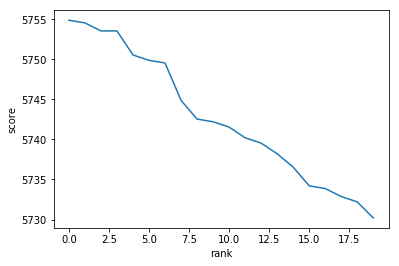

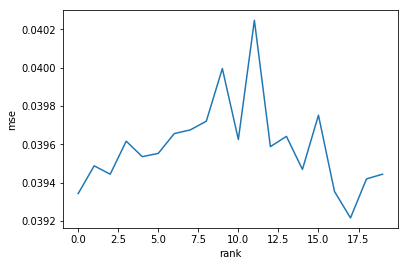

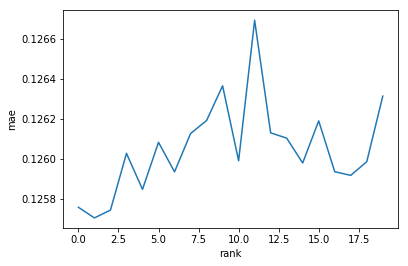

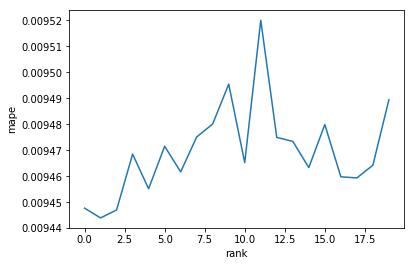

In [71]:
for name in metrics:
    plt.plot(df_gsearch_results[name])
    plt.xlabel('rank'); plt.ylabel(name); plt.show()

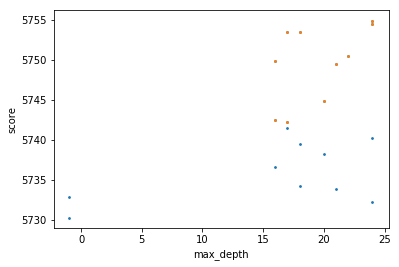

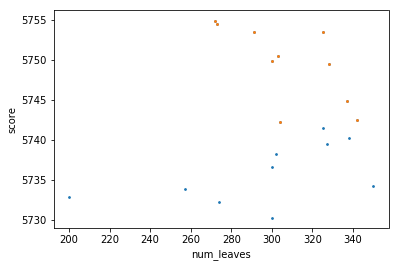

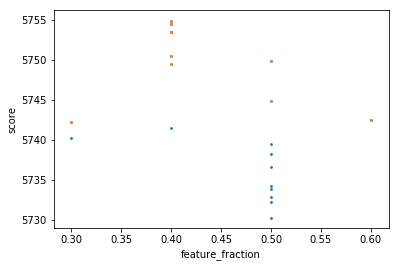

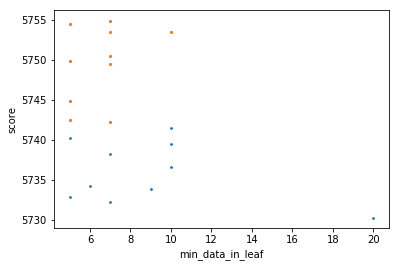

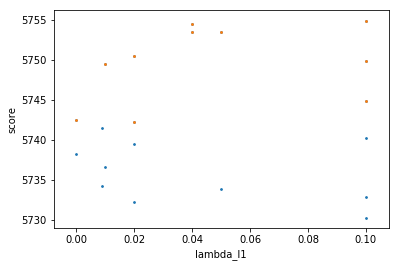

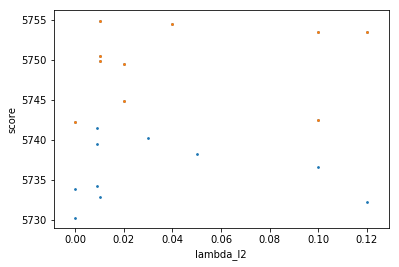

In [72]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['score'], s=3)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['score'][:10], s=3)
    plt.xlabel(p); plt.ylabel('score'); plt.show()

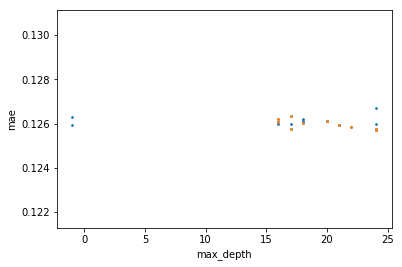

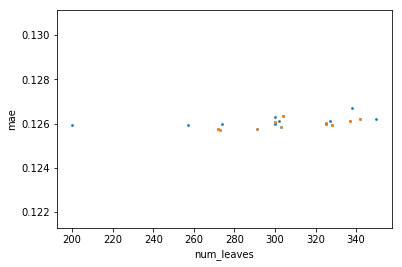

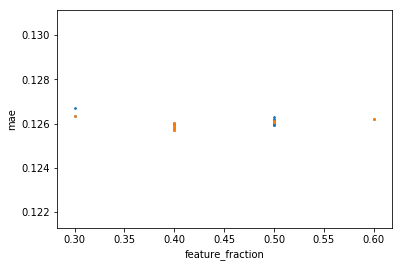

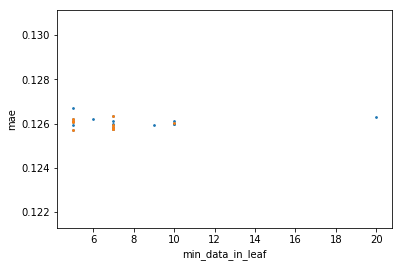

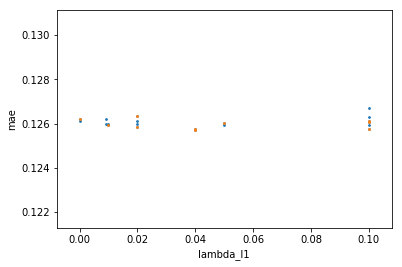

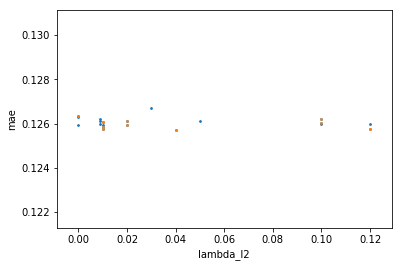

In [73]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['mae'], s=3)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['mae'][:10], s=3)
    plt.xlabel(p); plt.ylabel('mae'); plt.show()

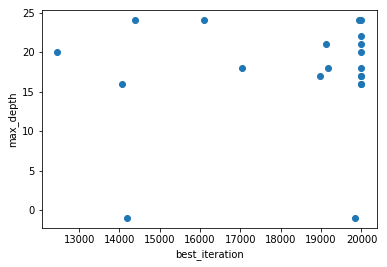

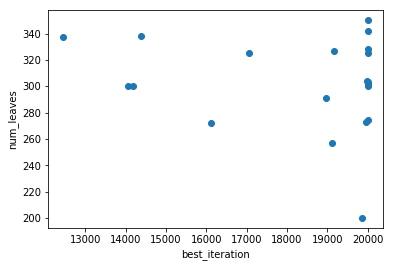

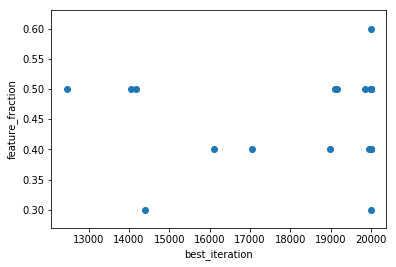

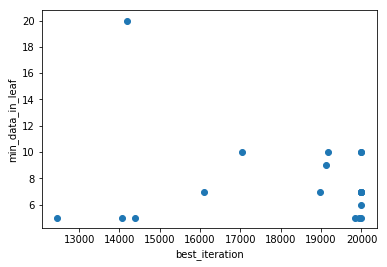

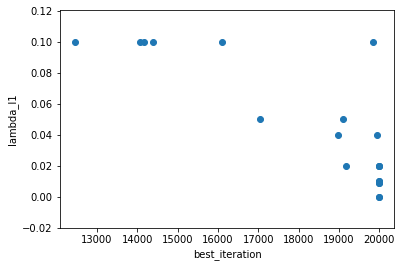

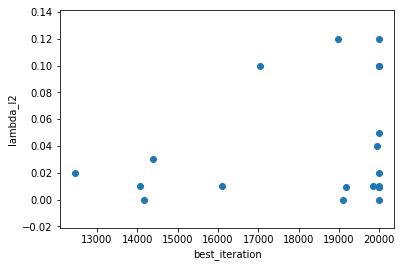

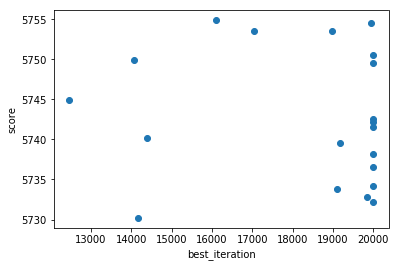

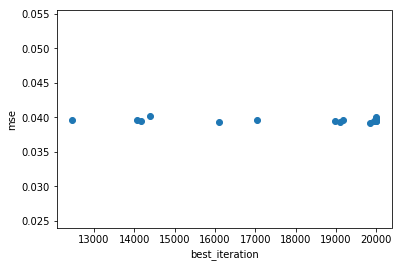

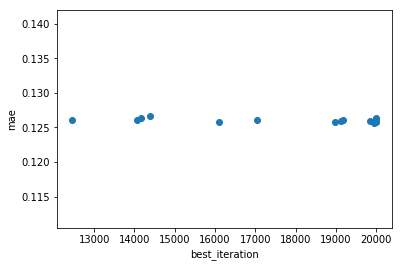

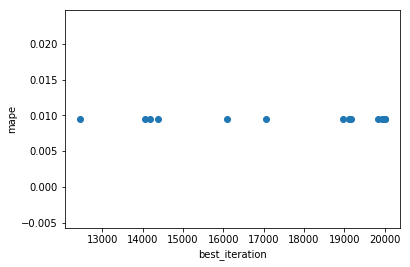

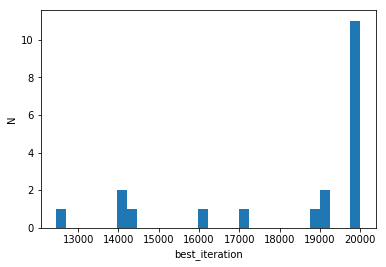

In [74]:
# best iteration
for c in df_gsearch_results.columns:
    if c != 'best_iteration':
        plt.scatter(df_gsearch_results['best_iteration'], df_gsearch_results[c])
        plt.ylabel(c)
    else:
        plt.hist(df_gsearch_results['best_iteration'], bins=30)
        plt.ylabel('N')        
    plt.xlabel('best_iteration')
    plt.show()

### Feature importance

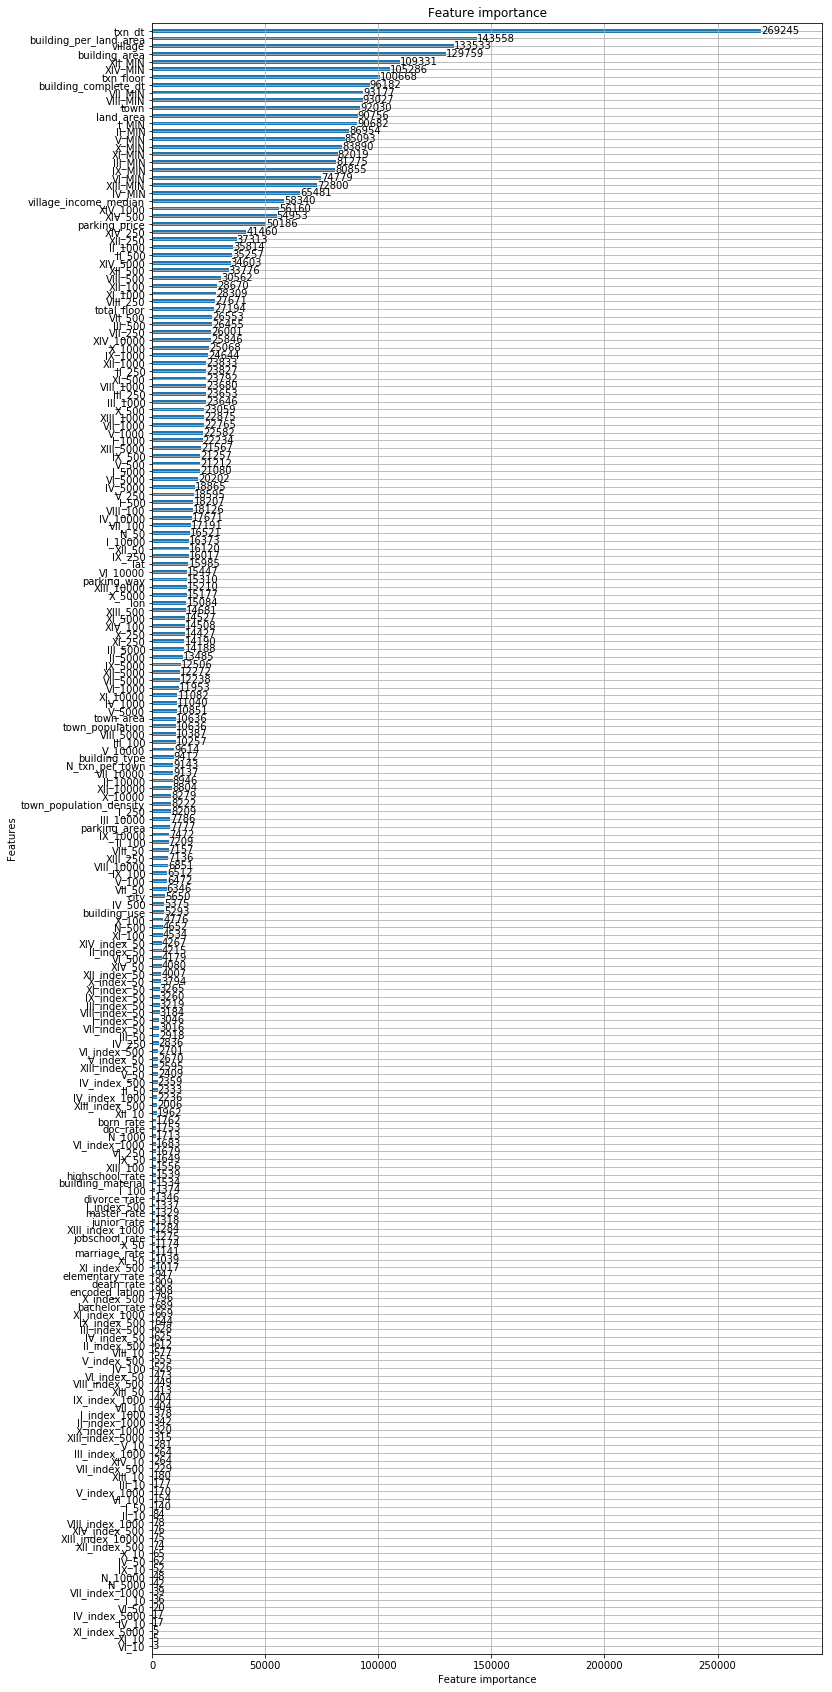

In [75]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5) # 050, 051, 052
plt.show()

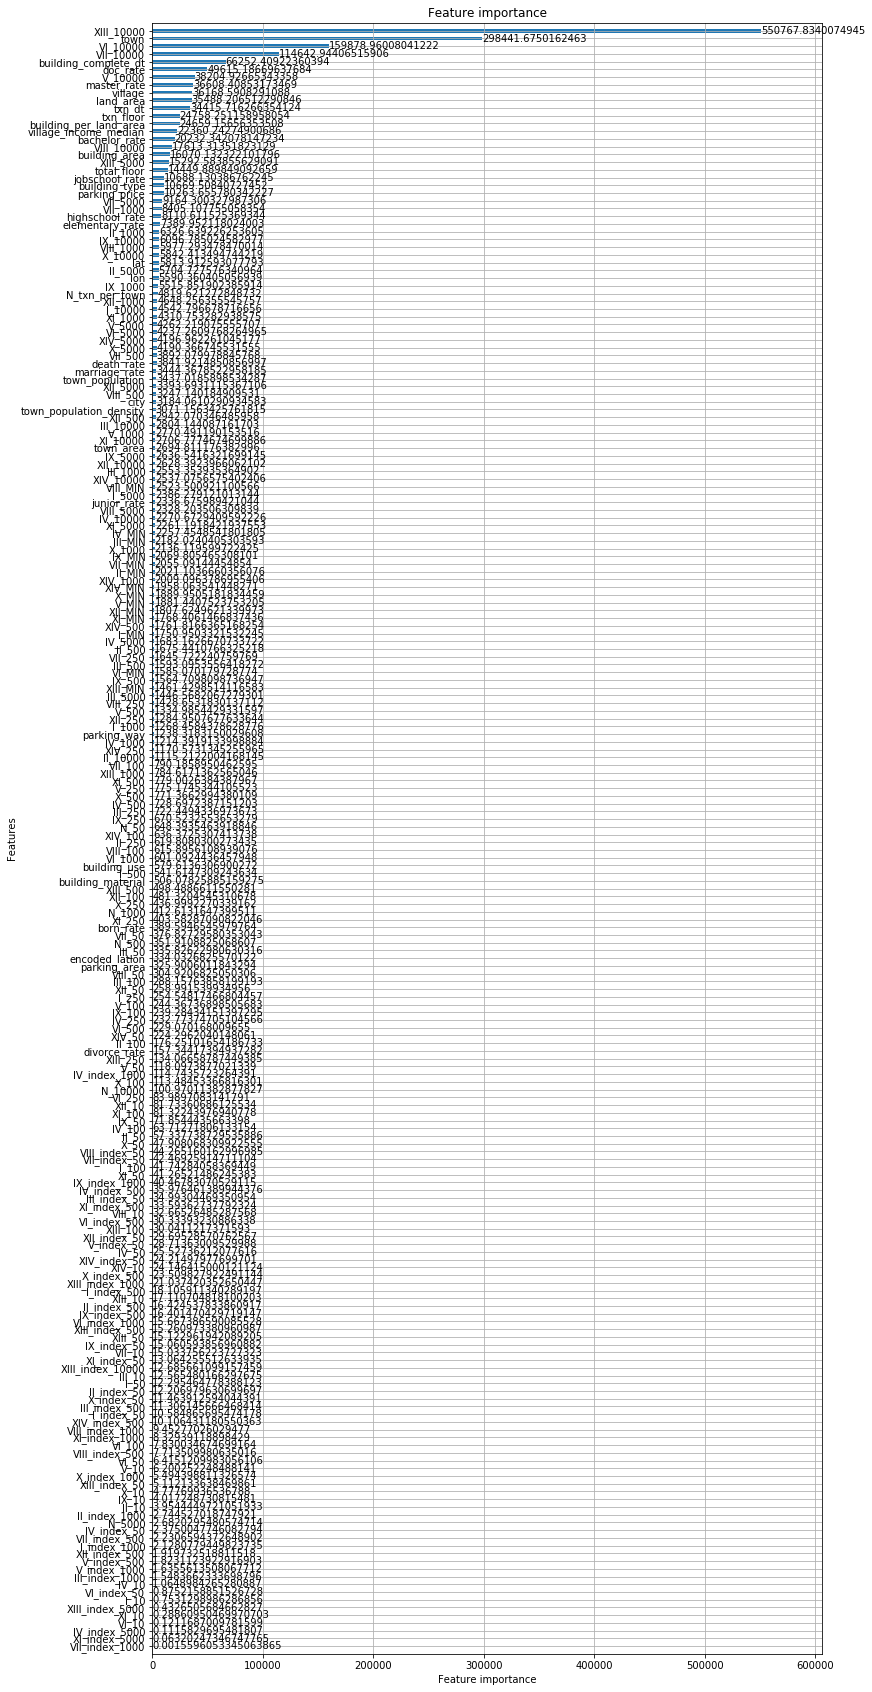

In [76]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5, importance_type='gain') # 050, 051, 052
plt.show()

### Result

(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 272), ('feature_fraction', 0.4), ('min_data_in_leaf', 7), ('lambda_l1', 0.1), ('lambda_l2', 0.01)) 5754.869350029374 0.03934233453505608 0.12575815576861715 0.009447701206692955 [5769.869583405929, 5757.870926245575, 5736.867540436617] [0.03827219841195957, 0.039815988804151735, 0.039938816389056934] [0.12511850591641127, 0.1257200784234707, 0.12643588296596953] [0.009405350251429329, 0.009429296961884133, 0.009508456406765406]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 273), ('feature_fraction', 0.4), ('min_data_in_leaf', 5), ('lambda_l1', 0.04), ('lambda_l2', 0.04)) 5754.536103055251 0.03948736675949972 0.12570523192780078 0.00944393209428886 [5758.86946932544, 5776.871151969371, 5727.867687870942] [0.03836331830133541, 0.040074112063925305, 0.040024669913238456] [0.12517805251047429, 0.12560225265318636, 0.1263353906197416] [0.00941070038805389, 0.009420058571613345, 0.009501037323199343]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 17), ('num_leaves', 291), ('feature_fraction', 0.4), ('min_data_in_leaf', 7), ('lambda_l1', 0.04), ('lambda_l2', 0.12)) 5753.536053734853 0.03944357031084742 0.12574429665220263 0.009446997582826772 [5767.869681703984, 5771.870966537782, 5720.867512962796] [0.038272932146849174, 0.040014694231683384, 0.04004308455400969] [0.1250245223901375, 0.12573068024301723, 0.12647768732345313] [0.009399458579405384, 0.009430744595110993, 0.00951078957396394]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 18), ('num_leaves', 325), ('feature_fraction', 0.4), ('min_data_in_leaf', 10), ('lambda_l1', 0.05), ('lambda_l2', 0.1)) 5753.535655100524 0.039616007885833325 0.1260272877523869 0.009468497121881718 [5756.869224112803, 5768.8706382117725, 5734.867102976997] [0.03851873968025402, 0.04015241098271457, 0.04017687299453139] [0.1254613836324534, 0.12593209349884227, 0.12668838612586503] [0.009431155683827163, 0.009446341548477323, 0.009527994133340661]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 22), ('num_leaves', 303), ('feature_fraction', 0.4), ('min_data_in_leaf', 7), ('lambda_l1', 0.02), ('lambda_l2', 0.01)) 5750.535914037927 0.03953522644727375 0.1258477307140762 0.00945518125572773 [5777.8696262574085, 5746.870725357914, 5726.867390498458] [0.03831723393899196, 0.04011207344338576, 0.04017637195944354] [0.12511638775186285, 0.12589918192089355, 0.1265276224694722] [0.009406627866557963, 0.009443722603853427, 0.009515193296771801]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.01)) 5749.869104448094 0.039552209905904225 0.12608247034422826 0.009471542638933838 [5761.86921633227, 5753.870747999082, 5733.867349012929] [0.03852071918832437, 0.040052479521862853, 0.04008343100752546] [0.125514781268547, 0.12603882722495469, 0.12669380253918308] [0.009435145432869866, 0.009453060575769444, 0.009526421908162205]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 21), ('num_leaves', 328), ('feature_fraction', 0.4), ('min_data_in_leaf', 7), ('lambda_l1', 0.01), ('lambda_l2', 0.02)) 5749.535802538491 0.03965561190817566 0.1259350407476031 0.00946166675566393 [5762.869427287506, 5761.870750556464, 5723.867229771501] [0.03848958432896614, 0.04021088193469243, 0.04026636946086843] [0.12524199083463936, 0.12587219666826532, 0.12669093473990453] [0.009415335810933524, 0.009441655344601523, 0.009528009111456742]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 20), ('num_leaves', 337), ('feature_fraction', 0.5), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.02)) 5744.869057941521 0.0396747423060119 0.12612602468879272 0.009475116188876703 [5760.869209410027, 5761.870654229468, 5711.86731018507] [0.03860934074331052, 0.040275156796071895, 0.04013972937865329] [0.12554983839164668, 0.12611589776499738, 0.12671233790973407] [0.0094375760430599, 0.00945914199988927, 0.009528630523680933]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 342), ('feature_fraction', 0.6), ('min_data_in_leaf', 5), ('lambda_l1', 0.0), ('lambda_l2', 0.1)) 5742.535669560059 0.03972039955518034 0.126191090863596 0.009480123399082385 [5752.869335370641, 5733.8702823134445, 5740.867390996091] [0.03848571049771282, 0.04038934322846435, 0.040286144939363853] [0.12540902036652857, 0.12641615493277875, 0.1267480972914807] [0.009428335380857971, 0.009482183580847174, 0.009529851235542008]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 17), ('num_leaves', 304), ('feature_fraction', 0.3), ('min_data_in_leaf', 7), ('lambda_l1', 0.02), ('lambda_l2', 0.0)) 5742.20200417732 0.039994982599765576 0.12636414723300318 0.00949548006693717 [5754.86859168922, 5777.870663721955, 5693.866757120784] [0.039011650405576824, 0.040433256900872, 0.040540040492847894] [0.12598374728143014, 0.12602326049423426, 0.12708543392334518] [0.009472215494172357, 0.009454182831532479, 0.009560041875106675]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 17), ('num_leaves', 325), ('feature_fraction', 0.4), ('min_data_in_leaf', 10), ('lambda_l1', 0.009), ('lambda_l2', 0.009)) 5741.535690193498 0.03962482241823593 0.1259905342111198 0.009465225531098602 [5768.8694492852255, 5743.870733562735, 5711.866887732534] [0.038514183692547194, 0.0401206763021987, 0.04023960725996189] [0.12529430419822546, 0.12588795382321713, 0.12678934461191688] [0.00941873812035309, 0.009442105151889237, 0.009534833321053478]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 338), ('feature_fraction', 0.3), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.03)) 5740.201677021291 0.04024714212947672 0.12669140646213636 0.009520084203704007 [5753.868368341022, 5768.870291576578, 5697.866371146277] [0.03922810643605426, 0.04066280347406569, 0.040850516478310214] [0.12617995067065643, 0.1263707848189952, 0.1275234838967575] [0.009487217943795614, 0.009480553898203507, 0.009592480769112899]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 18), ('num_leaves', 327), ('feature_fraction', 0.5), ('min_data_in_leaf', 10), ('lambda_l1', 0.02), ('lambda_l2', 0.009)) 5739.53562884932 0.03958742773931142 0.1261295517588188 0.009474947929841625 [5760.86927237245, 5746.870712737576, 5710.866901437935] [0.03844867063604406, 0.04009978653569237, 0.04021382604619783] [0.1254933605962518, 0.12604480896037823, 0.12685048571982635] [0.009433619655932557, 0.009452505177421057, 0.00953871895617126]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 20), ('num_leaves', 302), ('feature_fraction', 0.5), ('min_data_in_leaf', 7), ('lambda_l1', 0.0), ('lambda_l2', 0.05)) 5738.202402687036 0.039641085714727124 0.12610329472612586 0.009473415821098742 [5754.869312344362, 5742.870551836112, 5716.867343880635] [0.03853010317012449, 0.04030352649644869, 0.04008962747760819] [0.12543395854055178, 0.12623724709422154, 0.12663867854360428] [0.009429903478784795, 0.009467849951002315, 0.009522494033509113]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 10), ('lambda_l1', 0.01), ('lambda_l2', 0.1)) 5736.535773603576 0.03946870265888408 0.12597940151517062 0.009463332814564943 [5757.86933639212, 5735.870688792479, 5715.867295626128] [0.03837857711204691, 0.04000287238764705, 0.040024658476958276] [0.12541801668664038, 0.12603998255390125, 0.12648020530497023] [0.009427845472303591, 0.009452682085236013, 0.009509470886155223]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 18), ('num_leaves', 350), ('feature_fraction', 0.5), ('min_data_in_leaf', 6), ('lambda_l1', 0.009), ('lambda_l2', 0.009)) 5734.202297945118 0.03975156280756101 0.12618935122211414 0.009479883921898654 [5756.86918895696, 5736.870498206501, 5708.867206671893] [0.03866763838797143, 0.04036078805231196, 0.04022626198239963] [0.12557690992729434, 0.12622248459971114, 0.1267686591393369] [0.009439620104721703, 0.009467300911594834, 0.009532730749379425]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 21), ('num_leaves', 257), ('feature_fraction', 0.5), ('min_data_in_leaf', 9), ('lambda_l1', 0.05), ('lambda_l2', 0.0)) 5733.869191654682 0.03935363959206802 0.12593583476401293 0.00945976888296052 [5752.86953932925, 5741.870604452802, 5706.867431181996] [0.038187027520542906, 0.03998786461673467, 0.03988602663892648] [0.12521953633761873, 0.12607044626492744, 0.1265175216894926] [0.009412527992199094, 0.009454393412627042, 0.009512385244055423]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 200), ('feature_fraction', 0.5), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.01)) 5732.869273826179 0.03921544054599844 0.12591746923536082 0.009459340076053185 [5752.869572987737, 5720.8705656195025, 5724.867682871297] [0.03811596881535795, 0.039891829333120486, 0.03963852348951687] [0.12512441175246605, 0.1260999285036162, 0.12652806745000017] [0.009406947421002627, 0.009458349217082565, 0.009512723590074362]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 274), ('feature_fraction', 0.5), ('min_data_in_leaf', 7), ('lambda_l1', 0.02), ('lambda_l2', 0.12)) 5732.202493119649 0.03941924593576356 0.12598559443288804 0.009464238868334822 [5770.869441772318, 5722.870651630137, 5702.8673859564915] [0.03832971151732604, 0.03999627601333247, 0.03993175027663218] [0.12531912484102112, 0.12606319779667016, 0.12657446066097286] [0.009421080036285528, 0.009454133893382493, 0.009517502675336447]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 20), ('lambda_l1', 0.1), ('lambda_l2', 0.0)) 5730.201885188726 0.03944349477147404 0.12631282556892798 0.009489471230248812 [5750.8689642566715, 5728.869891017192, 5710.866800292314] [0.038449474791923156, 0.03993683290231507, 0.039944176620183895] [0.1257175364021894, 0.12654715032318456, 0.12667378998141002] [0.009450343686948434, 0.00949373931012235, 0.009524330693675651]